# Libraies and Settings

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

# Import Data

In [2]:
raw = pd.read_csv('../data/Zip_Zri_AllHomesPlusMultifamily.csv')
raw.columns = raw.columns.str.replace('RegionName', 'zip')

In [3]:
region = raw.iloc[:,:7].set_index('zip')

In [4]:
region

,RegionID,City,State,Metro,CountyName,SizeRank
zip,,,,,,
10025,61639,New York,NY,New York-Newark-Jersey City,New York County,1
60657,84654,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2
10023,61637,New York,NY,New York-Newark-Jersey City,New York County,3
77494,91982,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4
60614,84616,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5
...,...,...,...,...,...,...
26291,68966,Snowshoe,WV,NaN,Pocahontas County,13177
12720,62697,Bethel,NY,NaN,Sullivan County,13178
26209,68924,Snowshoe,WV,NaN,Pocahontas County,13179


In [5]:
data = pd.concat([raw['zip'],raw.iloc[:,11:-1]],axis=1).set_index('zip')

# Data Cleaning

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

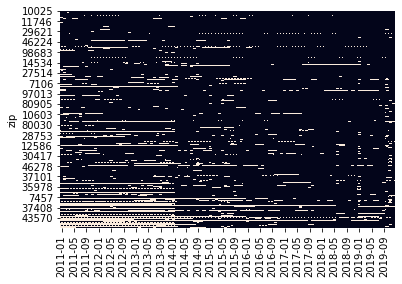

In [6]:
sns.heatmap(data.isnull(), cbar=False)

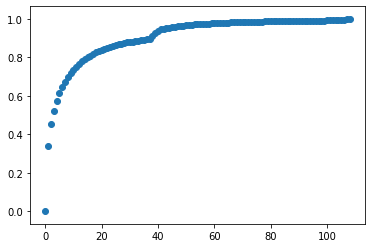

In [7]:
missingness = [np.mean(data.isna().sum(axis=1) < i) for i in range(12*9+1)]
plt.scatter(range(12*9+1),missingness)

In [8]:
data = data[data.isna().sum(axis=1) < 20]

# Train/Test Split

In [9]:
train = data.iloc[:,:-12]
test = data.iloc[:,-12:]

# Impute

In [10]:
train = train.interpolate(method='linear',limit_direction='both', axis=1)
test = test.interpolate(method='linear',limit_direction='both', axis=1)

# Build a Time Series Model for Each Zip Code

In [91]:
# one = train.iloc[0,:]
# mod = sm.tsa.statespace.SARIMAX(one, order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
# %time res = mod.fit(disp=False)
# # print(res.summary())
# print(res.arparams[0])
# print(res.seasonalarparams[0])
# print(res.pvalues[:2])

In [67]:
stat = pd.DataFrame(np.zeros(shape=(train.shape[0],4)),index=train.index,columns=['ar','p(ar)','s','p(s)'])
predict = pd.DataFrame(np.zeros(shape=(train.shape[0],12)),index=train.index,columns=[str(i) for i in range(1,13)])

In [161]:
# About 40 minutes
import warnings
warnings.filterwarnings('ignore')
nzip = train.shape[0]
for i in range(nzip):
    one = train.iloc[i,:]
    mod = sm.tsa.statespace.SARIMAX(one, order=(1,1,0), seasonal_order=(1,1,0,12),freq='MS')
    res = mod.fit(disp=False)
    stat.iloc[i,:] = [res.arparams[0],res.pvalues[0],res.seasonalarparams[0],res.pvalues[1]]
    predict.iloc[i,:] = res.predict('2019-01','2019-12').to_list()
#     print(i,' out of ', nzip)
#     print(stat.iloc[i,:])
#     print(predict.iloc[i,:])

In [174]:
pe = pd.DataFrame(np.zeros(shape=(train.shape[0],1)),index=train.index,columns=['Percentage Error'])
for i in range(nzip):
    testone = test.iloc[i,:].to_numpy()
    predictone = predict.iloc[i,:].to_numpy()
    pe.iloc[i,:] = np.sum(abs(predictone-testone)/testone)/12.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x144dba3d0>]],
      dtype=object)

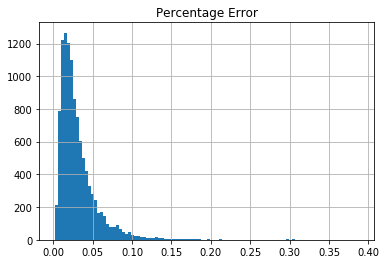

In [175]:
pe.hist(bins=100)

In [176]:
np.mean(pe)

Percentage Error    0.031226
dtype: float64

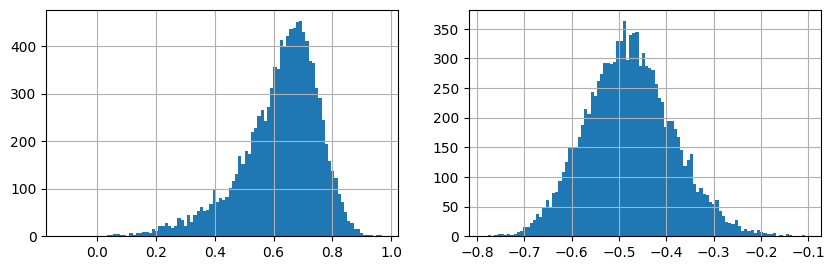

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(10,3), dpi=100)
stat['ar'].hist(bins=100,ax=axes[0])
stat['s'].hist(bins=100,ax=axes[1])

Text(0.5, 1.0, 'Seasonal Autoregression')

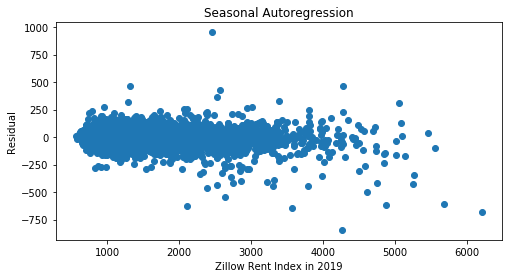

In [184]:
plt.figure(figsize=(8,4))
plt.scatter(test.mean(axis=1),predict.mean(axis=1)-test.mean(axis=1))
plt.xlabel('Zillow Rent Index in 2019')
plt.ylabel('Residual')
plt.title('Seasonal Autoregression')

Text(0.5, 1.0, 'Seasonal Autoregression')

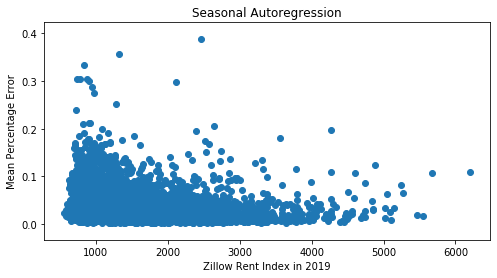

In [201]:
plt.figure(figsize=(8,4))
plt.scatter(test.mean(axis=1),pe)
plt.xlabel('Zillow Rent Index in 2019')
plt.ylabel('Mean Percentage Error')
plt.title('Seasonal Autoregression')

In [208]:
res = pd.concat([test.mean(axis=1),predict.mean(axis=1),pe],axis=1)
res.columns = ['ZRI','Predict','Percentage Error']

In [213]:
outlier = pe['Percentage Error'] > 0.2

In [214]:
region.merge(res[outlier],on='zip').sort_values('Percentage Error')

,RegionID,City,State,Metro,CountyName,SizeRank,ZRI,Predict,Percentage Error
zip,,,,,,,,,
7738,60784,Middletown Township,NJ,New York-Newark-Jersey City,Monmouth County,10634,2639.750000,2094.778005,0.206001
66064,87076,Osawatomie,KS,Kansas City,Miami County,10786,819.833333,991.145812,0.209110
27557,69410,Middlesex,NC,Rocky Mount,Nash County,9502,906.083333,1098.555957,0.212178
49097,79583,Vicksburg,MI,Kalamazoo-Portage,Kalamazoo County,8277,924.000000,1117.588140,0.212179
46952,78364,Marion,IN,Marion,Grant County,5036,725.541667,894.347661,0.239449
12828,62775,Town of Fort Edward,NY,Glens Falls,Washington County,8689,1283.416667,1606.695055,0.252379
85365,94941,Yuma,AZ,Yuma,Yuma County,1051,976.666667,708.606252,0.274175
36323,73832,Elba,AL,Enterprise,Coffee County,9633,947.458333,1217.674966,0.286714
80238,93314,Denver,CO,Denver-Aurora-Lakewood,Denver County,4711,2109.833333,1479.624076,0.298668


In [218]:
# train[outlier].T.plot(figsize=(12,12))